In [34]:
import numpy as np
import os
import random
import glob
import pandas as pd
import time
import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import fetch_covtype
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.io import arff
from sklearn.datasets import fetch_openml

In [35]:
%run 'common.ipynb'

In [36]:
# Shared variables
OUTPUT_FOLDER = 'csv_files'
FEATURE_FOLDER = 'features'
TEST_COUNT = 500

In [51]:
# %run covertype.ipynb
# %run kdd.ipynb
%run cicids.ipynb

In [52]:
# Should already be one hot encoded and label encoded
# all_df, main_labels, config = get_processed_covtype_df()
all_df, main_labels, config = get_processed_cicids_df()
TARGET_COLUMN = config['TARGET_COLUMN']
NORMAL_TARGET = config['NORMAL_TARGET']
TARGET_DICT = config['TARGET_DICT']
INV_TARGET_DICT = config['INV_TARGET_DICT']
NUMERICAL_COLUMNS = config['NUMERICAL_COLUMNS']
CATEGORICAL_COLUMNS = config['CATEGORICAL_COLUMNS']
ORDINAL_COLUMNS = config['ORDINAL_COLUMNS']
all_df.head()

Normal class:  0    Benign
Name: ClassLabel, dtype: object
TARGET_DICT {0: 'Benign', 1: 'Botnet', 2: 'Bruteforce', 3: 'DDoS', 4: 'DoS', 5: 'Infiltration', 6: 'Portscan', 7: 'Webattack'}
NORMAL_TARGET 0


,Unnamed: 0,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ClassLabel
0,334691,51990738,3,1,43.0,6.0,31.0,14.333333,14.433757,6.0,...,20,0.0,0.0,0.0,0.0,51940550.0,0.00,51940552.0,51940552.0,0
1,8039727,117384013,80,144,974.0,199741.0,275.0,12.175000,44.683636,1460.0,...,20,506187.0,628091.8,950315.0,62059.0,58155176.0,132745.16,58249039.0,58061309.0,0
2,4848412,246,2,2,64.0,204.0,32.0,32.000000,0.000000,102.0,...,32,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0
3,7260100,200929,13,11,1293.0,4610.0,694.0,99.461540,189.770750,1430.0,...,20,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0
4,4998983,2446230,8,7,1144.0,1581.0,677.0,143.000000,227.969920,1173.0,...,20,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0


In [61]:
all_df = all_df.loc[:, ~all_df.columns.str.contains('^Unnamed')]
all_df.head()
main_labels = main_labels[1:]
print(main_labels)

Index(['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
       'Fwd Packets Length Total', 'Bwd Packets Length Total',
       'Fwd Packet Length Max', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'SYN Flag Count',
       'URG Flag Count', 'Avg Packet Size', 'Avg Fwd Segment Size',
       'Avg Bwd Segment Size', 'Subflow Fwd Packets', 'Subflow Fwd Bytes',
       'Subflow Bwd Packets', 'Subflow Bwd By

In [62]:
all_df.shape

(2037240, 58)

In [63]:
# Create a folder to save the CSVs
remove_files_from_directory(OUTPUT_FOLDER)
remove_files_from_directory(FEATURE_FOLDER)
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(FEATURE_FOLDER, exist_ok=True)

All files in csv_files have been removed.
All files in features have been removed.


In [64]:
# Save all data as csv
all_df.to_csv('all_data.csv' ,index = False)

In [65]:
# Get X and y from all_df
X_df = all_df.drop(columns=[TARGET_COLUMN])
y_df = all_df[TARGET_COLUMN]

# Split the data into training and test sets
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2, random_state=42)
print(X_train_df.shape, X_test_df.shape, y_train_df.shape, y_test_df.shape)

(1629792, 57) (407448, 57) (1629792,) (407448,)


In [66]:
# Concatenate X_train and y_train along the columns (axis=1)
X_y_train_df = pd.concat([X_train_df, y_train_df], axis=1)
X_y_train_df.head()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ClassLabel
1285014,3850770,14,8,1440.0,1731.0,725.0,102.857140,191.172840,1179.0,216.375,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1142876,4664549,5,4,935.0,790.0,935.0,187.000000,418.144700,395.0,197.500,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1229394,1301287,6,5,455.0,338.0,140.0,75.833336,62.936210,145.0,67.600,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
957100,60002992,2,0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000,...,0,0.0,0.0,0.0,0.0,60000000.0,0.0,60000000.0,60000000.0,0
1567448,5048320,3,1,12.0,2.0,6.0,4.000000,3.464102,2.0,2.000,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [67]:
# Initialize the standard scaler
scaler = StandardScaler()

# Fit and transform the numeric columns
X_train_scaled_df = X_train_df.copy()
X_train_scaled_df[NUMERICAL_COLUMNS] = scaler.fit_transform(X_train_scaled_df[NUMERICAL_COLUMNS])
# print('X_train_scaled_df', X_train_scaled_df)

# Use the same scaler to transform X_test
X_test_scaled_df = X_test_df.copy()
X_test_scaled_df[NUMERICAL_COLUMNS] = scaler.transform(X_test_scaled_df[NUMERICAL_COLUMNS])
# print('X_test_scaled_df', X_test_scaled_df)

In [68]:
# Loop through each cover type and create a dataset
benign = 2359289
abnormal_type_counts = all_df[TARGET_COLUMN].value_counts()
abnormal_type_dict = abnormal_type_counts.to_dict()
print('abnormal_type_dict', abnormal_type_dict)

benign_ratio = 2  # Adjust this ratio as needed
min_benign_samples = 50  # Ensure at least 50 benign samples are always included

for label, name in TARGET_DICT.items():
    if label == NORMAL_TARGET:
        continue  # Skip the normal target
    
    a, b = 0, 0  # Track abnormal and benign sample counts
    
    # Open the output file for writing
    output_path = os.path.join(OUTPUT_FOLDER, f"{name}.csv")
    with open(output_path, "w") as ths:
        ths.write(','.join(main_labels) + "\n")
        
        # Calculate the number of benign samples based on the fixed ratio
        abnormal_count = abnormal_type_dict[label]
        benign_num = max(min(int(abnormal_count * benign_ratio), benign), min_benign_samples)
        # print(f'Creating {name}.csv with {benign_num} benign samples and {abnormal_count} abnormal samples.')

        # Collect normal (benign) rows and abnormal rows
        benign_rows = []
        abnormal_rows = []

        # Read all_data.csv line by line and collect rows
        with open("all_data.csv", "r") as file:
            for i, line in enumerate(file):
                if i == 0:
                    continue  # Skip the header row
                k = line.strip().split(",")  # Strip newline and split the line
                
                # Collect normal rows
                if int(k[-1]) == NORMAL_TARGET:
                    benign_rows.append(line)
                
                # Collect abnormal rows that match the current label
                elif int(k[-1]) == label:
                    abnormal_rows.append(line)

        # Randomly sample benign rows
        if len(benign_rows) > benign_num:
            benign_rows = random.sample(benign_rows, benign_num)
        else:
            benign_rows = random.sample(benign_rows, len(benign_rows))  # Shuffle if fewer than required

        # Concatenate benign and abnormal rows
        combined_rows = benign_rows + abnormal_rows
        
        # Shuffle the combined rows
        random.shuffle(combined_rows)

        # Write the shuffled rows to the output file
        for row in combined_rows:
            ths.write(row)

        # Print number of rows written
        b = len(benign_rows)
        a = len(abnormal_rows)
        print(f"{name}.csv created with {a + b} rows. ({b} benign and {a} abnormal rows)")

print("All datasets created successfully!")

abnormal_type_dict {0: 1597040, 3: 274283, 4: 87943, 1: 32390, 2: 23289, 5: 21107, 7: 686, 6: 502}
Botnet.csv created with 97170 rows. (64780 benign and 32390 abnormal rows)
Bruteforce.csv created with 69867 rows. (46578 benign and 23289 abnormal rows)
DDoS.csv created with 822849 rows. (548566 benign and 274283 abnormal rows)
DoS.csv created with 263829 rows. (175886 benign and 87943 abnormal rows)
Infiltration.csv created with 63321 rows. (42214 benign and 21107 abnormal rows)
Portscan.csv created with 1506 rows. (1004 benign and 502 abnormal rows)
Webattack.csv created with 2058 rows. (1372 benign and 686 abnormal rows)
All datasets created successfully!


In [70]:
# tdf = pd.read_csv('csv_files/smurf.csv')
# tdf['attack'].unique()

array([27])

csv_files ['Bruteforce.csv', 'Portscan.csv', 'Botnet.csv', 'Infiltration.csv', 'DoS.csv', 'DDoS.csv', 'Webattack.csv']
csv file Bruteforce.csv
importances [2.09145547e-04 1.56165287e-03 3.60166921e-05 1.29903833e-03
 3.46510926e-04 2.52425112e-04 5.67585074e-03 9.93767169e-05
 3.67697787e-03 2.03697311e-05 1.95407289e-05 1.69855094e-05
 8.60478063e-05 1.06117173e-04 4.90702283e-05 8.40858833e-05
 6.39621224e-05 5.31272137e-05 6.02500273e-05 2.62537482e-05
 4.19207871e-05 1.52580798e-04 3.46267371e-05 5.55837988e-05
 4.75304239e-05 5.61118678e-05 1.72408217e-05 5.48134284e-03
 6.73087258e-04 2.07342211e-02 3.62622550e-04 1.18755612e-03
 9.36149383e-03 7.11213898e-03 1.24533360e-02 9.07436832e-03
 0.00000000e+00 2.10050533e-04 1.69564399e-03 6.27020167e-03
 4.42763775e-04 1.52361225e-03 1.07968339e-03 3.82494182e-05
 3.41180392e-04 2.05451625e-03 1.54121723e-03 8.51247082e-01
 5.29050484e-02 6.93273746e-06 6.65549818e-06 8.00713550e-06
 7.75160346e-06 6.93744307e-06 6.12422519e-06 1.0288

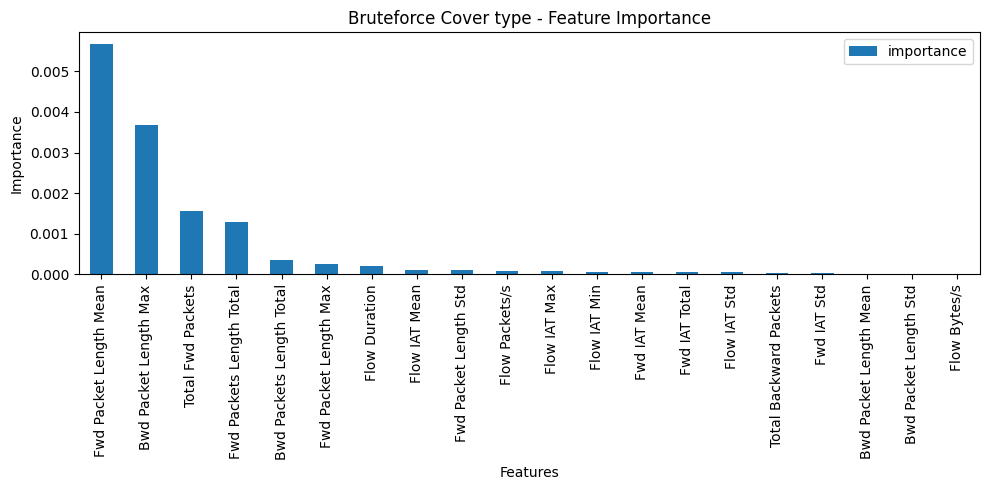

-----------------------------------------------------------------------------------------------




csv file Portscan.csv
importances [2.51381570e-03 2.24313814e-03 3.70885730e-03 2.82722121e-03
 8.22656284e-04 2.87560803e-03 2.33052400e-03 4.67501524e-04
 1.08820799e-03 2.52271016e-03 4.97966989e-02 2.95817397e-03
 1.55854931e-03 1.86042184e-03 7.70346214e-04 2.65135114e-03
 2.03447814e-01 8.35271560e-04 9.66994755e-04 4.79353540e-02
 1.08846601e-03 1.62462285e-03 3.03341152e-03 2.31847975e-03
 5.52015659e-04 1.81158756e-03 4.10756965e-03 1.10304472e-03
 2.83179745e-03 3.92964106e-03 3.19575718e-03 9.38660660e-03
 3.30425120e-03 6.35314143e-03 2.36920531e-01 2.35169983e-01
 1.11965039e-03 7.23537372e-02 1.55385693e-02 2.66286371e-03
 2.84195375e-03 3.24966229e-03 2.44223892e-03 3.73872019e-03
 1.17471505e-03 1.37194680e-02 1.96057924e-02 6.18690801e-04
 5.23222422e-03 1.30008832e-03 3.06928050e-05 1.16920899e-03
 1.56914312e-03 2.13007610e-04 0.00000000e+00 2.43341125e-04
 2.64108404e

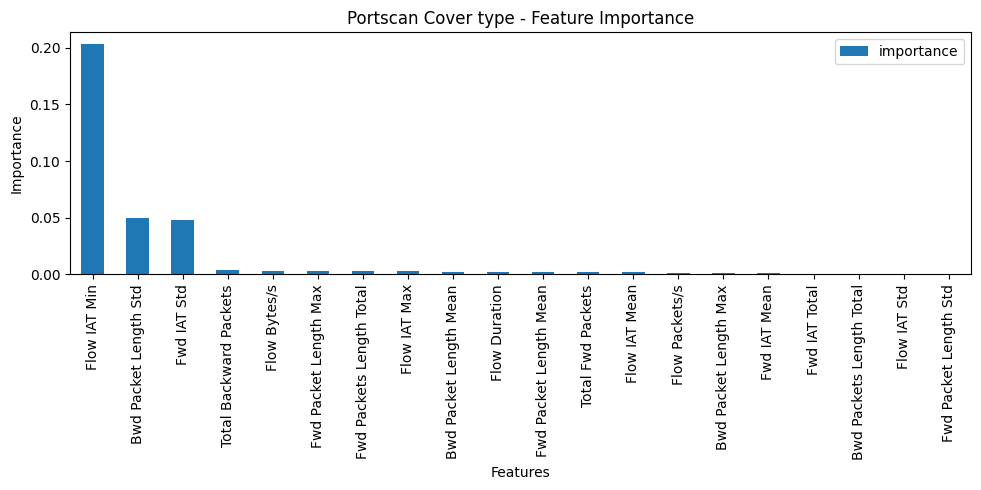

-----------------------------------------------------------------------------------------------




csv file Botnet.csv
importances [4.26325497e-01 3.71758727e-04 3.62600983e-05 9.46552906e-05
 3.50851703e-03 8.92181452e-04 1.48976789e-04 3.82044899e-04
 2.12937287e-03 5.07367908e-04 5.55975366e-04 1.02762684e-03
 6.42874398e-04 3.67448194e-03 7.83396977e-05 4.33871115e-04
 1.63087232e-03 6.19813397e-04 3.84693709e-04 1.29758557e-03
 3.25273651e-04 3.07174255e-03 5.92343206e-05 2.79780607e-03
 4.37250406e-03 4.32247325e-04 1.13299634e-03 1.03875325e-06
 5.11621784e-04 1.29231332e-04 7.66857918e-04 4.90709190e-01
 1.48831926e-03 6.54643263e-03 8.53693768e-04 8.56432362e-04
 6.33101161e-06 7.18699120e-05 2.76173533e-02 1.74548707e-04
 5.66834556e-04 3.72012207e-04 1.34506605e-04 2.66951754e-05
 3.32605227e-03 4.87552648e-03 3.12747666e-03 1.00853661e-04
 3.14768215e-04 2.88404971e-05 5.52494061e-06 2.38516457e-05
 2.55361101e-05 3.81733915e-05 4.14945073e-06 4.99428545e-06
 3.56712378e-0

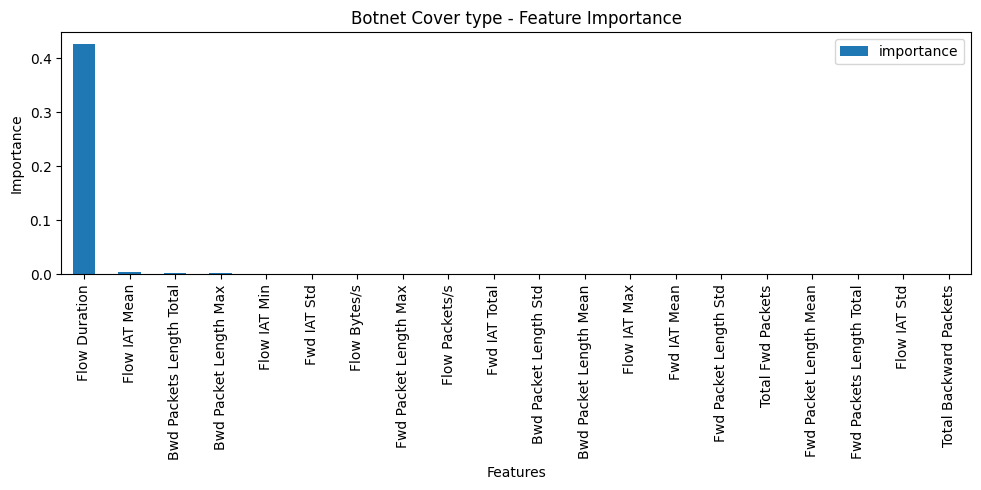

-----------------------------------------------------------------------------------------------




csv file Infiltration.csv
importances [0.03121075 0.00127836 0.00135682 0.009303   0.01198076 0.0108713
 0.010237   0.00851473 0.00815634 0.00869707 0.00542224 0.06102722
 0.02064212 0.02147841 0.0200903  0.04054509 0.06303285 0.02303103
 0.01469913 0.0179279  0.02043833 0.07255179 0.02239846 0.01429328
 0.01072359 0.01265513 0.02272742 0.00032577 0.00720342 0.01663599
 0.03648336 0.02281122 0.01885023 0.01582498 0.01316261 0.0132319
 0.00062163 0.00100768 0.0164904  0.01011433 0.00833032 0.00111741
 0.00935068 0.0012949  0.01120421 0.09022877 0.02179394 0.01155878
 0.05908668 0.00359645 0.00172965 0.00301328 0.00750185 0.00503809
 0.00311743 0.01983231 0.00415134] Infiltration
important_features ['Flow IAT Min', 'Flow Bytes/s', 'Flow IAT Max', 'Flow Duration', 'Fwd IAT Total']
Infiltration importance list:
Infiltration 
                           importance
Features                     

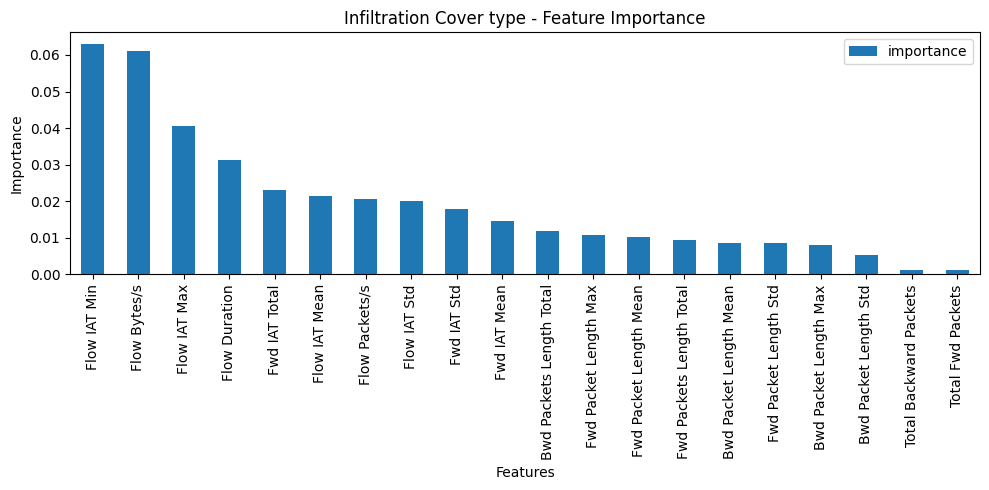

-----------------------------------------------------------------------------------------------




csv file DoS.csv
importances [7.67187002e-04 1.96451252e-04 2.16592528e-03 1.25874068e-03
 5.48805181e-04 5.65198753e-03 9.91358694e-03 9.53585362e-04
 5.93924842e-03 3.65560660e-04 2.90131793e-02 1.72062670e-03
 2.73715253e-04 2.86063945e-03 2.02622099e-04 4.97196879e-04
 1.73989678e-03 6.59569011e-03 1.92186936e-03 2.32587049e-04
 7.41151740e-04 3.07410390e-03 8.89990278e-05 5.57170388e-03
 8.09971018e-05 9.33859907e-05 7.92932224e-04 1.10433473e-02
 2.44807672e-01 8.15437899e-04 3.52983615e-04 3.86944202e-01
 6.71207553e-03 3.56066251e-03 1.06583900e-03 8.47860660e-04
 2.70685606e-03 7.18428558e-03 1.86242173e-03 1.00488741e-02
 4.55364496e-04 1.89935342e-04 1.00508911e-03 2.24095203e-03
 4.86842101e-04 9.29762987e-02 1.33262688e-01 3.18126840e-04
 6.26808627e-03 2.59142063e-04 1.06697525e-04 2.77948420e-04
 6.57743168e-04 6.59253288e-05 1.82321094e-05 9.19989576e-05
 1.04037503e-04] 

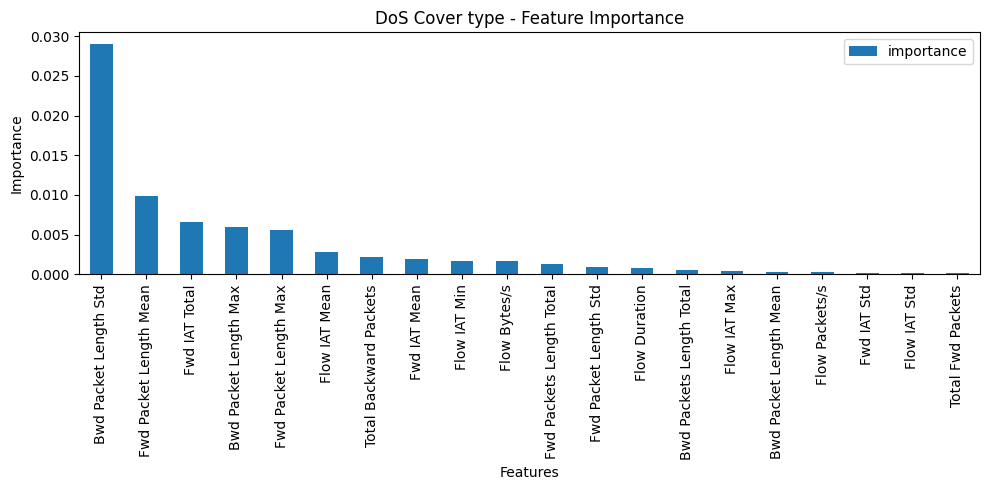

-----------------------------------------------------------------------------------------------




csv file DDoS.csv
importances [1.59442943e-02 2.17203851e-05 5.84407049e-03 5.93200589e-02
 1.33834560e-04 2.04500880e-01 1.00024473e-01 1.28884564e-04
 2.31838857e-04 1.43176108e-04 1.01338535e-04 6.47312215e-04
 1.10799294e-04 1.76789021e-04 3.78863409e-03 8.95307198e-05
 4.32221967e-03 1.70214026e-04 3.22820653e-04 2.38329542e-05
 1.17710266e-04 1.51119831e-02 8.39488697e-05 1.30481318e-03
 4.41636690e-05 5.27671074e-05 5.04203562e-05 1.27796189e-05
 1.01795582e-01 6.53692878e-03 3.96744492e-04 7.00791125e-03
 3.82779618e-04 1.18138479e-04 1.97099030e-04 1.87407416e-04
 8.42254434e-04 9.90883417e-05 3.57296938e-04 1.17402852e-01
 1.32622627e-04 1.78608848e-05 5.76758177e-02 6.24803922e-03
 1.23919397e-04 2.78712793e-01 1.04642119e-03 1.56897688e-03
 5.00468680e-04 5.73590243e-04 4.10398757e-06 5.74300622e-04
 4.39287350e-04 7.28658871e-06 1.05405885e-06 3.44553160e-06
 4.22062141e-03]

In [ ]:
seconds = time.time()

# CSV files names:
csv_files=os.listdir(OUTPUT_FOLDER)# It creates a list of file names in the "attacks" folder.
print('csv_files',csv_files)

ths = open("importance_list.csv", "w")
feature_importances = {}
SVMs = {}
for csv_file in csv_files:
    print('csv file', csv_file)
    
    X_df, y_df, df = get_anomaly_X_y_from_csv(csv_file, main_labels, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER)

    #computing the feature importances
    forest = sk.ensemble.RandomForestRegressor(n_estimators=250,random_state=0)
    forest.fit(X_df, y_df)
    importances = forest.feature_importances_
    label = csv_file.split(".")[0]
    print('importances', importances, label)
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    refclasscol=list(df.columns.values)
    impor_bars = pd.DataFrame({'Features':refclasscol[0:20],'importance':importances[0:20]})
    impor_bars = impor_bars.sort_values('importance',ascending=False)
    important_features = impor_bars['Features'].to_list()[:5]
    impor_bars = impor_bars.set_index('Features')
    print('important_features', important_features)
    feature_importances[label] = important_features

    X_scaled_df = X_df.copy()
    X_scaled_df[NUMERICAL_COLUMNS] = scaler.transform(X_scaled_df[NUMERICAL_COLUMNS])

    svm = SVC()
    X_train_class = df.iloc[:, df.columns.get_indexer(important_features)]
    # print('X_train_class', X_train_class)
    y_train_class = y_df
    # print('y_train_class', y_train_class)
    if len(y_train_class) > 0:  # Ensure there are samples for this class
        svm.fit(X_train_class, y_train_class)
    else:
        print(f'no data for {label}')
    SVMs[label] = svm

    
    plt.rcParams['figure.figsize'] = (10, 5)
    impor_bars.plot.bar();
    #printing the feature importances  
    count=0
    fea_ture=label+"=["
    for i in impor_bars.index:
        fea_ture=fea_ture+"\""+str(i)+"\","
        count+=1
        if count==5:
            fea_ture=fea_ture[0:-1]+"]"
            break     
    print(label,"importance list:")
    print(label,"\n",impor_bars.head(20),"\n\n\n")
    print(fea_ture)
    plt.title(label+" Cover type - Feature Importance")
    plt.ylabel('Importance')
    plt.savefig(os.path.join(FEATURE_FOLDER, label+".pdf"),bbox_inches='tight', format = 'pdf')
    ths.write((  fea_ture ) )
    plt.tight_layout()
    plt.show()
    print("-----------------------------------------------------------------------------------------------\n\n\n\n")

print('feature_importances', feature_importances)
print("Total operation time: = ",time.time()- seconds ,"seconds")
ths.close()


In [26]:
seconds = time.time()

# Step 1: Train KNN to classify
knn = KNeighborsClassifier(n_neighbors=5)
# knn.fit(X_train_scaled_df, y_train_df)
knn.fit(X_train_df, y_train_df)

# Step 2: Predict classes for the test set
X_test_df = X_test_df[:TEST_COUNT]
X_test_scaled_df = X_test_scaled_df[:TEST_COUNT]
y_test_df = y_test_df[:TEST_COUNT]

# knn_predictions = knn.predict(X_test_scaled)
knn_predictions = knn.predict(X_test_df)
print('knn_predictions', knn_predictions)

print("Total operation time: = ",time.time()- seconds ,"seconds")

knn_predictions [1 2 2 2 2 3 2 1 2 2 2 1 5 2 2 1 2 5 3 2 1 2 2 1 6 1 1 2 1 2 1 2 2 3 2 2 2
 2 2 1 2 1 1 2 2 1 2 1 7 2 1 1 6 2 1 1 7 2 2 2 2 1 1 2 2 2 3 2 2 1 5 1 2 3
 1 3 1 1 1 2 2 1 2 2 2 1 1 3 1 2 1 1 2 1 3 3 2 2 1 1 6 6 2 2 1 2 5 6 6 1 2
 1 2 1 1 1 3 1 2 3 1 1 1 1 2 2 1 1 1 2 1 2 2 2 5 1 1 1 2 3 1 2 2 3 1 1 1 2
 2 2 1 7 2 2 1 1 2 2 1 2 1 3 1 2 2 2 2 2 2 2 2 1 2 1 1 1 1 2 2 2 1 2 2 2 2
 2 1 2 2 1 1 1 2 2 1 3 3 2 1 1 2 7 1 1 1 1 2 2 2 3 2 2 3 6 2 1 2 1 2 2 3 1
 2 2 3 2 2 2 1 1 2 5 1 1 1 2 2 1 2 2 1 1 2 1 1 6 2 1 2 7 2 1 3 5 1 2 3 2 2
 1 2 2 1 2 2 2 2 1 1 2 1 2 1 1 2 6 1 3 2 7 1 1 2 2 2 2 2 2 7 1 1 1 1 1 2 2
 5 2 2 2 1 6 2 1 1 2 7 1 2 3 2 2 2 2 2 6 1 5 2 2 1 6 2 2 1 1 1 1 2 2 2 7 3
 3 2 1 2 2 2 3 2 2 1 2 1 1 2 1 7 2 1 3 3 5 2 2 1 3 3 2 2 1 2 2 2 2 2 2 1 2
 2 1 2 2 1 2 2 1 2 2 2 1 2 1 3 1 3 2 1 2 6 2 3 2 2 1 2 2 6 1 2 1 2 2 2 2 1
 2 2 7 2 2 5 1 2 1 1 2 2 2 1 7 1 2 2 1 6 2 2 1 1 2 2 2 6 2 2 5 1 6 1 1 2 1
 2 1 1 6 1 1 1 3 1 1 1 2 2 1 6 2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 6 1 2 1 1 1 1
 2 7 1 1 

-----KNN Evaluation-----
Confusion Matrix:
[[173   3   0   0   0   0   0]
 [  5 232   0   0   0   0   0]
 [  0   0  35   0   0   2   0]
 [  0   0   0   0   0   1   0]
 [  0   2   0   0  12   0   0]
 [  0   0   1   0   0  19   0]
 [  0   0   0   0   0   0  15]]


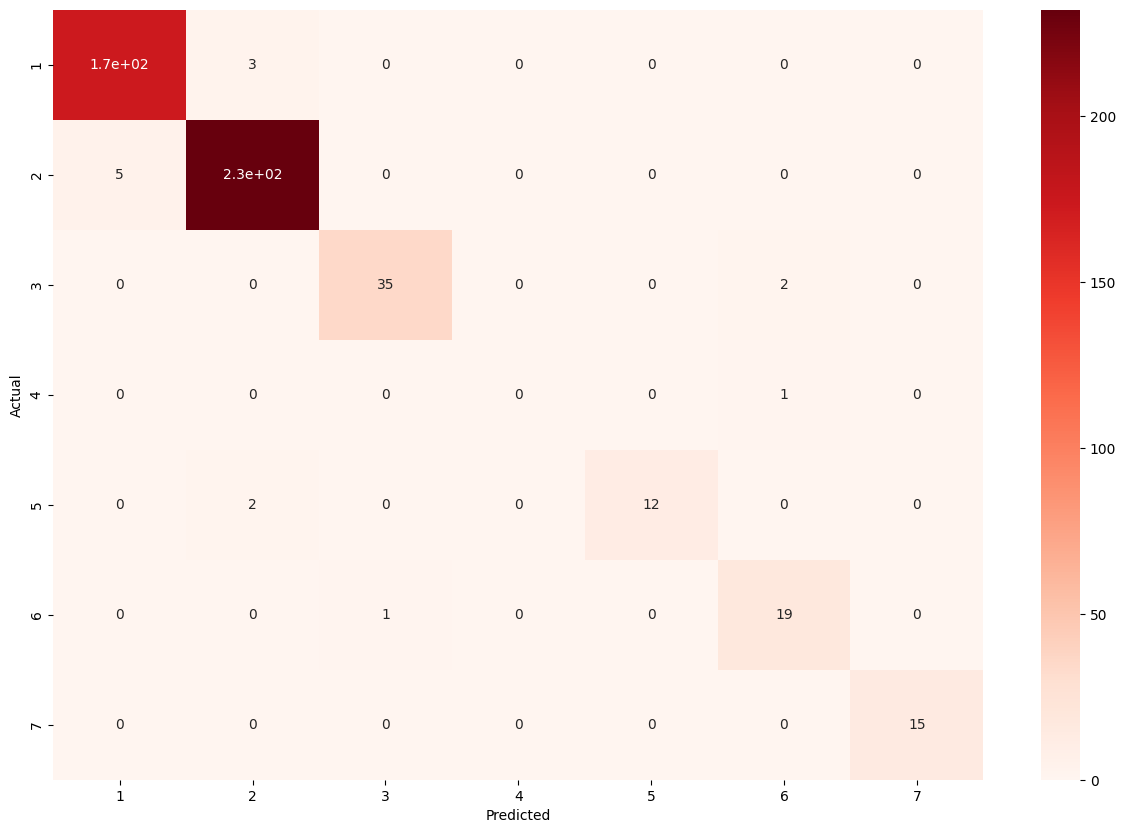


Classification Report:
              precision    recall  f1-score   support

           1       0.97      0.98      0.98       176
           2       0.98      0.98      0.98       237
           3       0.97      0.95      0.96        37
           4       0.00      0.00      0.00         1
           5       1.00      0.86      0.92        14
           6       0.86      0.95      0.90        20
           7       1.00      1.00      1.00        15

    accuracy                           0.97       500
   macro avg       0.83      0.82      0.82       500
weighted avg       0.97      0.97      0.97       500

Accuracy: 0.972


/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [30]:
evaluate(y_test_df, knn_predictions, heading='-----KNN Evaluation-----')

In [31]:
svm_predictions = []
seconds = time.time()

for i in range(len(X_test_scaled_df)):
    test_instance_df = X_test_scaled_df.iloc[i].to_frame().T
    if knn_predictions[i] == NORMAL_TARGET:
        svm_predictions.append((0, NORMAL_TARGET, y_test_df.iloc[i]))
        continue
    predicted_label = TARGET_DICT[knn_predictions[i]]
    # print('predicted_label', predicted_label)
    selected_features = feature_importances[predicted_label]
    # print('selected_features', selected_features)
    svm_model = SVMs[predicted_label]
    
    # Select features for the SVM
    test_instance_selected_df = test_instance_df[selected_features]
    svm_prediction = svm_model.predict(test_instance_selected_df)
    print('svm prediction: ', svm_prediction, 'knn prediction: ', INV_TARGET_DICT[predicted_label], 'actual value: ', y_test_df.iloc[i])
    svm_predictions.append((svm_prediction, INV_TARGET_DICT[predicted_label], y_test_df.iloc[i]))

print("Total operation time: = ",time.time()- seconds ,"seconds")

svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  3 actual value:  3
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [1] knn prediction:  5 actual value:  5
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [1] knn prediction:  5 actual value:  5
svm prediction:  [0] knn prediction:  3 actual value:  3
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  6 actual value:  6
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  3 actual value:  3
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn predic

anomaly_mask 500
[1, 2, 2, 2, 2, 3, 2, 1, 2, 2, 2, 1, 5, 2, 2, 1, 2, 5, 3, 2, 1, 2, 2, 1, 6, 1, 1, 2, 1, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 7, 2, 1, 1, 6, 2, 1, 1, 7, 2, 2, 2, 2, 1, 1, 2, 2, 2, 3, 2, 2, 1, 5, 1, 2, 3, 1, 3, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 3, 1, 2, 1, 1, 2, 1, 3, 3, 2, 2, 1, 1, 6, 6, 2, 2, 1, 2, 5, 6, 6, 1, 2, 1, 2, 1, 1, 1, 3, 1, 2, 3, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 5, 1, 1, 1, 2, 3, 1, 2, 2, 3, 1, 1, 1, 2, 2, 2, 1, 7, 2, 2, 1, 1, 2, 2, 1, 2, 1, 3, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 3, 3, 2, 1, 1, 2, 7, 1, 1, 1, 1, 2, 2, 2, 3, 2, 2, 3, 6, 2, 1, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 2, 2, 1, 1, 2, 5, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 6, 2, 1, 2, 7, 2, 1, 3, 5, 1, 2, 3, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 6, 1, 3, 2, 7, 1, 1, 2, 2, 2, 2, 2, 2, 7, 1, 1, 1, 1, 1, 2, 2, 5, 2, 2, 2, 1, 6, 2, 1, 1, 2, 7, 1, 2, 3, 2, 2, 2, 2, 2, 6, 1, 5, 2, 2, 1, 6, 2, 2, 1, 1, 1, 1

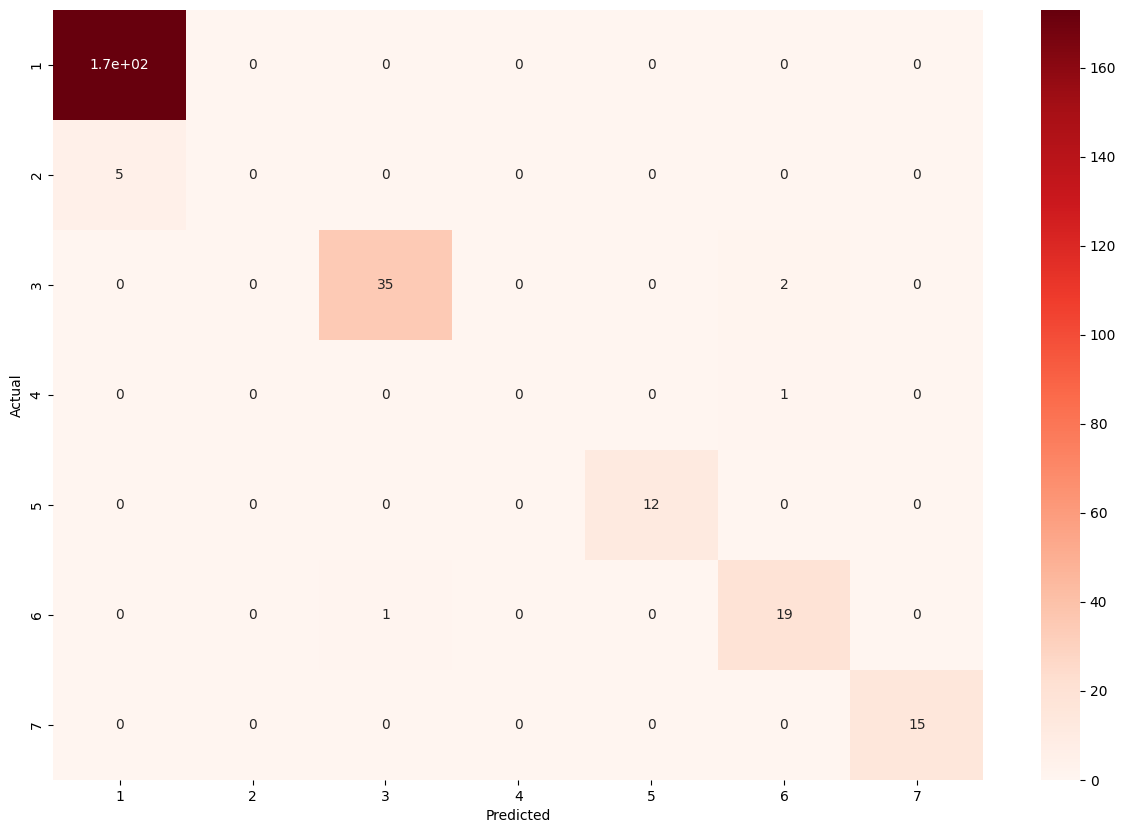


Classification Report:
              precision    recall  f1-score   support

           1       0.97      1.00      0.99       173
           2       0.00      0.00      0.00         5
           3       0.97      0.95      0.96        37
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00        12
           6       0.86      0.95      0.90        20
           7       1.00      1.00      1.00        15

    accuracy                           0.97       263
   macro avg       0.69      0.70      0.69       263
weighted avg       0.94      0.97      0.95       263

Accuracy: 0.9657794676806084


/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [32]:
# Now evaluate SVM predictions only for the anomalies detected by KNN
# Create a mask for test instances that KNN classified as anomalies
anomaly_mask = knn_predictions != NORMAL_TARGET  # Assuming normal_target is your normal class
print('anomaly_mask', len(anomaly_mask))

# Get true labels and predictions for anomalies
svm_predictions_actual = [t[1] for t in svm_predictions]
print(svm_predictions_actual)
# svm_predictions_actual = np.array(svm_predictions_actual)
svm_predictions_actual_df = pd.DataFrame(svm_predictions_actual, columns=[TARGET_COLUMN])
y_test_anomalies_df = y_test_df[anomaly_mask]
svm_predictions_anomalies_df = svm_predictions_actual_df[anomaly_mask]
print('Lengths: ', len(y_test_anomalies_df), len(svm_predictions_anomalies_df))

# Evaluate SVM only on the anomalies
evaluate(y_test_anomalies_df, svm_predictions_anomalies_df, heading='SVM Evaluation (for anomalies)')

SVM Evaluation (for all)
Confusion Matrix:
[[173   3   0   0   0   0   0]
 [  5 232   0   0   0   0   0]
 [  0   0  35   0   0   2   0]
 [  0   0   0   0   0   1   0]
 [  0   2   0   0  12   0   0]
 [  0   0   1   0   0  19   0]
 [  0   0   0   0   0   0  15]]


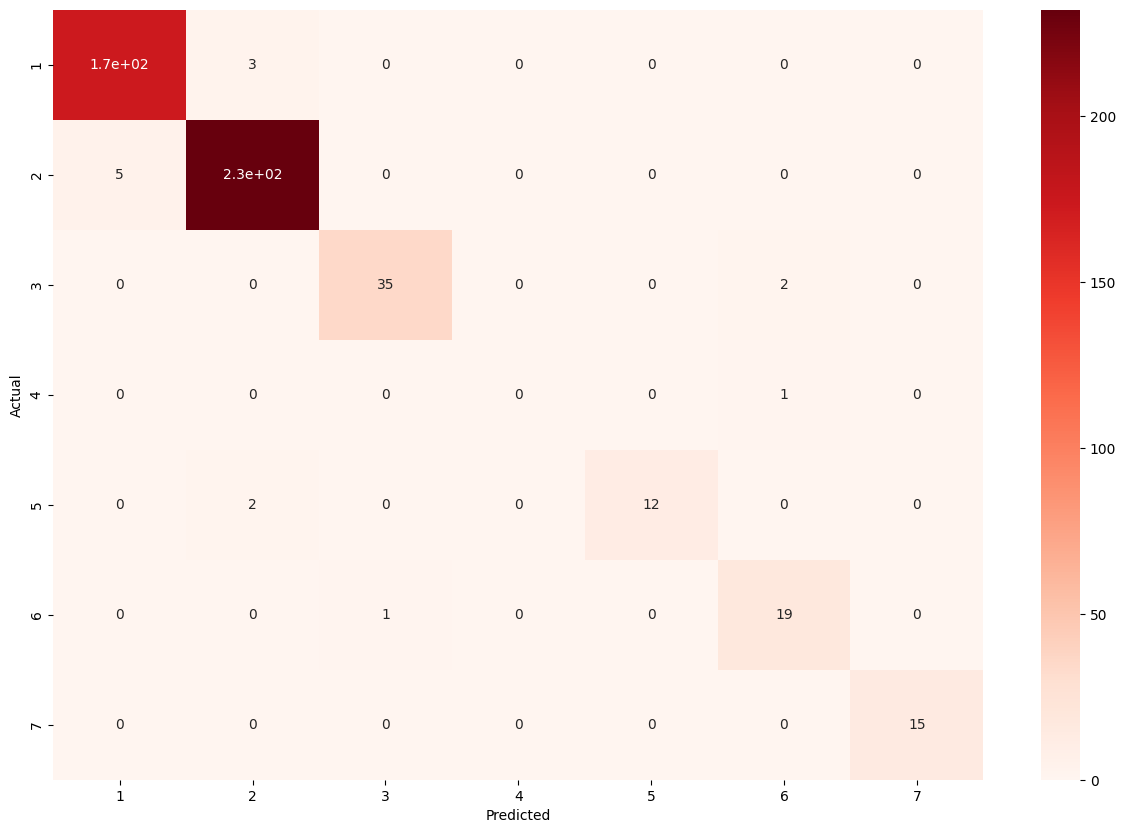


Classification Report:
              precision    recall  f1-score   support

           1       0.97      0.98      0.98       176
           2       0.98      0.98      0.98       237
           3       0.97      0.95      0.96        37
           4       0.00      0.00      0.00         1
           5       1.00      0.86      0.92        14
           6       0.86      0.95      0.90        20
           7       1.00      1.00      1.00        15

    accuracy                           0.97       500
   macro avg       0.83      0.82      0.82       500
weighted avg       0.97      0.97      0.97       500

Accuracy: 0.972


/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [33]:
evaluate(y_test_df, svm_predictions_actual_df, heading='SVM Evaluation (for all)')